In [1]:
%load_ext autoreload
%autoreload 2

In [48]:
from os.path import join
from glob import glob
import numpy as np
import torch
import matplotlib.pyplot as plt

from cac.data.audio import AudioItem
from cac.data.transforms import DataProcessor, BackgroundNoiseOnImage
from cac.utils.viz import plot_raw_audio_signal, plot_spectrogram_image

In [3]:
DATA_DIR = "/data/wiai-facility/"

In [4]:
all_audio_files = glob(join(DATA_DIR, "processed", "audio", "*.wav"))

In [5]:
len(all_audio_files)

83838

### Testing on a sample

In [10]:
signal = np.load('../../../cache/sample_signal.npy')

In [11]:
spec = np.load('../../../cache/logmelspec_of_sample_signal.npy')

In [12]:
signal.shape, spec.shape

((310271,), (64, 704))

In [15]:
spec = torch.from_numpy(spec)

In [16]:
spec.shape

torch.Size([64, 704])

In [26]:
noise_transform_cfg = [
    {
        "name": "Resample",
        "params": {
            "orig_freq": 44100,
            "new_freq": 16000
        }
    },
    {
        "name": "Spectrogram",
        "params": {
            "n_fft": 512,
            "win_length": 512,
            "hop_length": 160
        }
    },
    {
        "name": "MelScale",
        "params": {
            "n_mels": 64,
            "sample_rate": 16000,
            "f_min": 125,
            "f_max": 7500
        }
    },
    {
        "name": "AmplitudeToDB",
        "params": {}
    },
]

In [35]:
bg_noise_on_image = BackgroundNoiseOnImage(
    dataset_config=[{"name": "esc-50", "version": "default", "mode": "all"}],
    noise_transform_cfg=noise_transform_cfg,
    min_noise_scale=0.4,
    max_noise_scale=0.75,
)

Loading items: 100%|██████████| 2000/2000 [00:00<00:00, 340460.57it/s]


In [36]:
noisy_spec = bg_noise_on_image(spec)

In [37]:
noisy_spec.shape

torch.Size([64, 704])

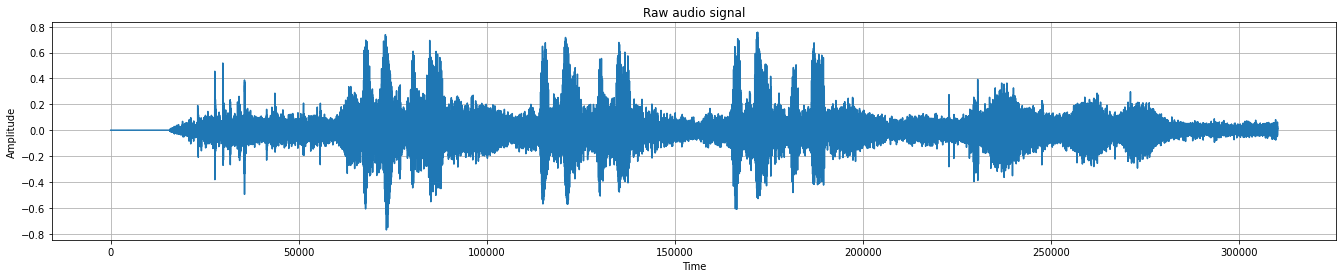

In [39]:
plot_raw_audio_signal(signal)

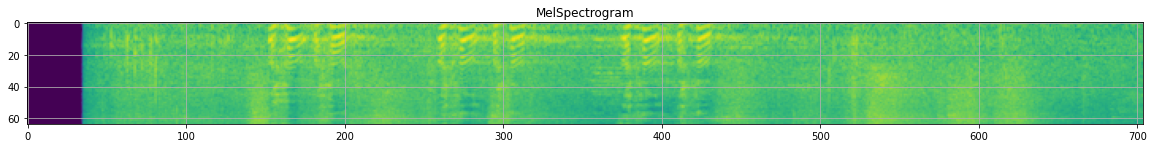

In [33]:
plot_spectrogram_image(spec)

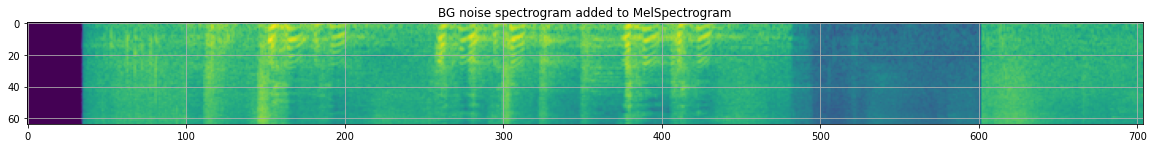

In [40]:
plot_spectrogram_image(noisy_spec, title="BG noise spectrogram added to MelSpectrogram")

In [58]:
np.save('../../../cache/spec_noise_added_spec_for_sample_audio.npy', noisy_spec)

### Define transforms to be applied on spectrograms

In [46]:
transforms_cfg = [
    {
        "name": "BackgroundNoiseOnImage",
        "params": {
            "dataset_config": [
                {
                    "name": "esc-50",
                    "version": "default",
                    "mode": "all"
                }
            ],
            "min_noise_scale": 0.4,
            "max_noise_scale": 0.75
        }
    },
    {
        "name": "TimeMasking",
        "params": {
            "max_len": 50,
            "max_num": 2
        }
    },
    {
        "name": "FrequencyMasking",
        "params": {
            "max_len": 50,
            "max_num": 2
        }
    },
    {
        "name": "Rescale",
        "params": {
            "value": 100
        }
    },
    {
        "name": "Unsqueeze",
        "params": {}
    }

]

In [49]:
transforms = DataProcessor(transforms_cfg)

Loading items: 100%|██████████| 2000/2000 [00:00<00:00, 388397.44it/s]


In [51]:
spec.shape

torch.Size([64, 704])

In [55]:
transformed_spec = transforms(spec)

In [56]:
transformed_spec.shape

torch.Size([1, 64, 704])

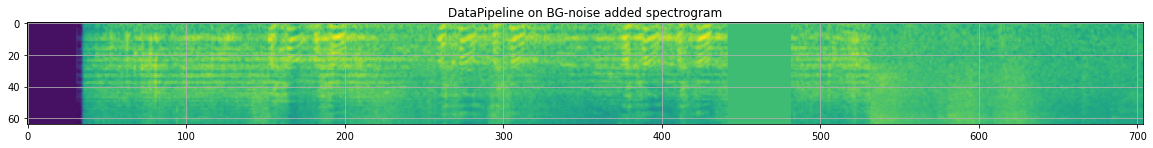

In [57]:
plot_spectrogram_image(transformed_spec[0].numpy(), title="DataPipeline on BG-noise added spectrogram")